In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive')

In [ ]:
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib as mpl

#Standard imports

In [ ]:
!pip install pytorch_lightning
import torch
import numpy as np
import torch.nn as nn
import dynamic_selection as ds
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader,Subset, TensorDataset
from torchmetrics import Accuracy, AUROC
from dynamic_selection import MaskingPretrainer, GreedyDynamicSelection,BaseModel
import pandas as pd

#Dataset

In [ ]:
# Load dataset.
dataset = ds.data.load_spam()
d_in = dataset.input_size    # 57
d_out = dataset.output_size  # 2
# Normalize and split dataset.
mean = dataset.tensors[0].mean(dim=0)
dataset.tensors = (dataset.tensors[0] - mean, dataset.tensors[1])
train_dataset, val_dataset, test_dataset = ds.data.data_split(dataset)

In [ ]:
# Prepare dataloaders.
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, pin_memory=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=1024, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=1024, pin_memory=True)

#Networks

In [ ]:
# Set up networks
hidden = 128
dropout = 0.3

predictor = nn.Sequential(
    nn.Linear(2 * d_in, hidden),
    nn.ReLU(),
    nn.Dropout(dropout),
    nn.Linear(hidden, hidden),
    nn.ReLU(),
    nn.Dropout(dropout),
    nn.Linear(hidden, d_out))

selector = nn.Sequential(
    nn.Linear(2 * d_in, hidden),
    nn.ReLU(),
    nn.Dropout(dropout),
    nn.Linear(hidden, hidden),
    nn.ReLU(),
    nn.Dropout(dropout),
    nn.Linear(hidden, d_in))

In [ ]:
# Pretrain predictor.
mask_layer = ds.utils.MaskLayer(append=True)
pretrain = MaskingPretrainer(predictor, mask_layer).cuda()
pretrain.fit(
    train_loader,
    val_loader,
    lr=1e-3,
    nepochs=15,#100
    loss_fn=nn.CrossEntropyLoss(),
    verbose=True)

--------Epoch 1--------
Val loss = 1.0461

--------Epoch 2--------
Val loss = 0.9948

--------Epoch 3--------
Val loss = 0.9821

--------Epoch 4--------
Val loss = 0.9756

--------Epoch 5--------
Val loss = 0.9767

--------Epoch 6--------
Val loss = 0.9921

--------Epoch 7--------
Val loss = 0.9746

--------Epoch 8--------
Val loss = 0.9786

--------Epoch 9--------
Val loss = 0.9683

--------Epoch 10--------
Val loss = 0.9746

--------Epoch 11--------
Val loss = 0.9875

--------Epoch 12--------
Val loss = 0.9771

Epoch 00012: reducing learning rate of group 0 to 2.0000e-04.
--------Epoch 13--------
Val loss = 0.9575

--------Epoch 14--------
Val loss = 0.9535

--------Epoch 15--------
Val loss = 0.9555



In [ ]:
# Train selector and predictor jointly.
gdfs = GreedyDynamicSelection(selector, predictor, mask_layer).cuda()
gdfs.fit(
    train_loader,
    val_loader,
    lr=1e-3,
    nepochs=15,#250
    start_temp=0.3,
    temp_steps=1,
    max_features=35,
    loss_fn=nn.CrossEntropyLoss(),
    verbose=True)

Starting training with temp = 0.3000

epoch is 0

--------Epoch 1 (1 total)--------
Val loss = 0.4587, Zero-temp loss = 0.4586

epoch is 1

--------Epoch 2 (2 total)--------
Val loss = 0.4591, Zero-temp loss = 0.4591

epoch is 2

--------Epoch 3 (3 total)--------
Val loss = 0.4492, Zero-temp loss = 0.4491

epoch is 3

--------Epoch 4 (4 total)--------
Val loss = 0.4376, Zero-temp loss = 0.4371

epoch is 4

--------Epoch 5 (5 total)--------
Val loss = 0.4582, Zero-temp loss = 0.4578

epoch is 5

--------Epoch 6 (6 total)--------
Val loss = 0.4389, Zero-temp loss = 0.4388

epoch is 6

--------Epoch 7 (7 total)--------
Val loss = 0.4333, Zero-temp loss = 0.4330

epoch is 7

--------Epoch 8 (8 total)--------
Val loss = 0.3826, Zero-temp loss = 0.3825

epoch is 8

--------Epoch 9 (9 total)--------
Val loss = 0.4142, Zero-temp loss = 0.4139

epoch is 9

--------Epoch 10 (10 total)--------
Val loss = 0.3803, Zero-temp loss = 0.3803

epoch is 10

--------Epoch 11 (11 total)--------
Val loss = 

# Evaluate performance

- AUROC and top-1 accuracy increase quickly with the number of selections
- Performance can often be improved by increasing the `patience` parameter, or increasing the number of temperature steps (`temp_steps`)

In [ ]:
# For saving results.
num_features = list(range(1, 11)) + list(range(15, 30, 5))
auroc_list = []
acc_list = []

# Metrics (softmax is applied automatically in recent versions of torchmetrics).
auroc_metric = lambda pred, y: AUROC(task='multiclass', num_classes=d_out)(pred.softmax(dim=1), y)
acc_metric = Accuracy(task='multiclass', num_classes=d_out)

# Evaluate.
for num in num_features:
    auroc, acc = gdfs.evaluate(test_loader, num, (auroc_metric, acc_metric))
    auroc_list.append(auroc)
    acc_list.append(acc)
    print(f'Num = {num}, AUROC = {100*auroc:.2f}, Acc = {100*acc:.2f}')

Num = 1, AUROC = 83.04, Acc = 64.27
Num = 2, AUROC = 93.03, Acc = 78.76
Num = 3, AUROC = 93.91, Acc = 80.16
Num = 4, AUROC = 95.00, Acc = 83.64
Num = 5, AUROC = 95.06, Acc = 83.29
Num = 6, AUROC = 96.57, Acc = 85.43
Num = 7, AUROC = 97.35, Acc = 86.01
Num = 8, AUROC = 97.41, Acc = 85.99
Num = 9, AUROC = 97.21, Acc = 85.48
Num = 10, AUROC = 97.85, Acc = 87.23
Num = 15, AUROC = 98.43, Acc = 89.31
Num = 20, AUROC = 97.90, Acc = 87.27
Num = 25, AUROC = 97.88, Acc = 87.79


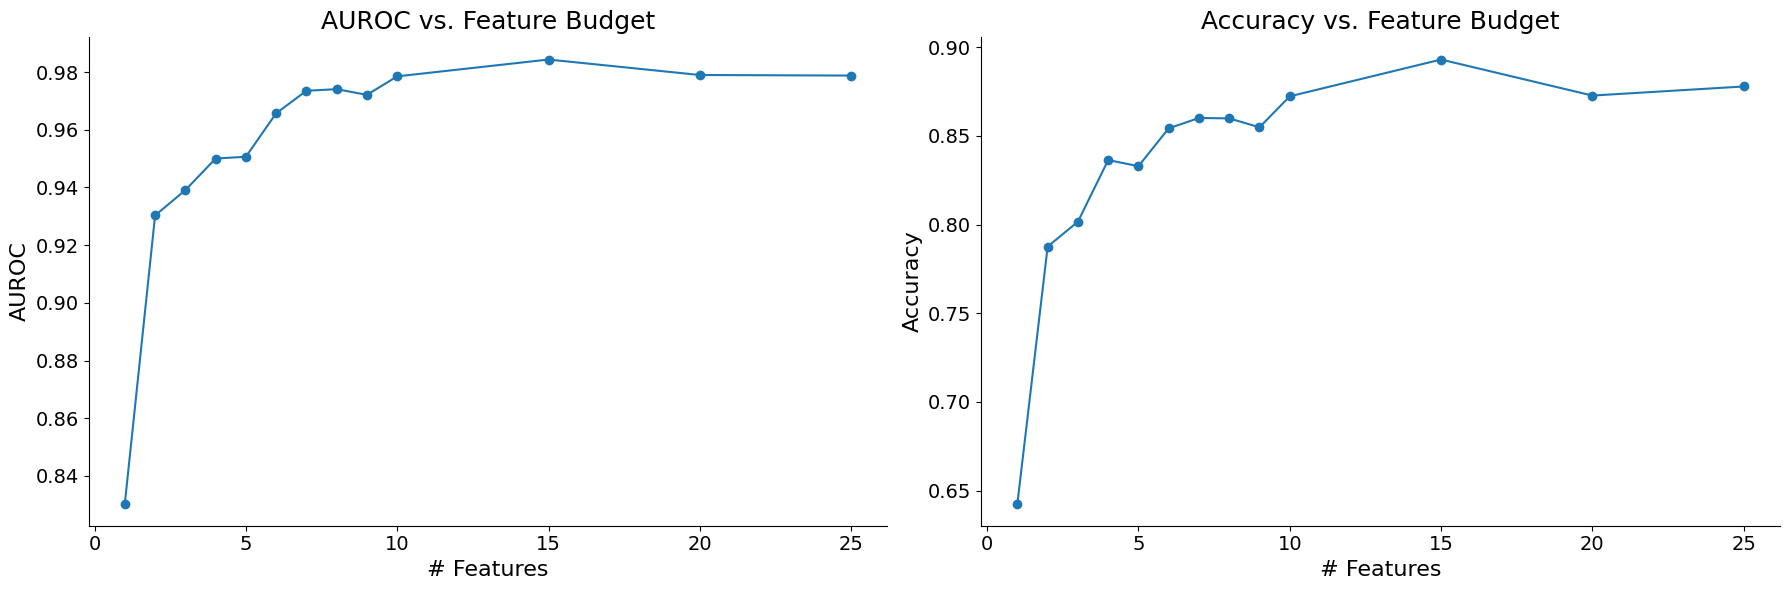

In [ ]:
# Plot results
fig, axarr = plt.subplots(1, 2, figsize=(18, 6))

# AUROC
plt.sca(axarr[0])
plt.plot(num_features, auroc_list, marker='o')
plt.xlabel('# Features', fontsize=16)
plt.ylabel('AUROC', fontsize=16)
plt.title('AUROC vs. Feature Budget', fontsize=18)
plt.tick_params(labelsize=14)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# Accuracy
plt.sca(axarr[1])
plt.plot(num_features, acc_list, marker='o')
plt.xlabel('# Features', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.title('Accuracy vs. Feature Budget', fontsize=18)
plt.tick_params(labelsize=14)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.tight_layout()
plt.show()

# Plot selections

In [ ]:
# Generate selections for entire test set.
num_features = range(1, 20)
p_list = []

#for num in num_features:
print(str(20)+'\n')
x, y = ds.data.get_xy(test_dataset)
x_np=x.numpy()
x_test_df=pd.DataFrame(x_np)
pred, x_masked, m = gdfs(x.cuda(), max_features=20)
p = m.mean(dim=0)
print('\n P is \n')
p_list.append(p.cpu().numpy())
print(p)
print(p_list)

20


 P is 

tensor([0.3092, 1.0000, 0.1029, 0.8412, 1.0000, 0.0000, 0.4405, 1.0000, 1.0000,
        0.9995, 0.6243, 1.0000, 0.3229, 1.0000, 0.9864, 0.0000, 0.7719, 1.0000,
        0.4576, 0.0000, 0.7930, 1.0000, 0.0000, 0.8952, 0.1603, 0.0000, 0.4670,
        0.0000, 0.9979, 0.1317, 0.8625, 1.0000, 0.0000, 0.8359],
       device='cuda:0')
[array([0.30921012, 0.99999994, 0.10286351, 0.84121186, 0.99999994,
       0.        , 0.4405447 , 0.99999994, 0.99999994, 0.99949116,
       0.6243245 , 0.99999994, 0.32286096, 0.99999994, 0.98641884,
       0.        , 0.77187026, 0.99999994, 0.4576175 , 0.        ,
       0.7930338 , 0.99999994, 0.        , 0.8951711 , 0.16031034,
       0.        , 0.4670094 , 0.        , 0.997932  , 0.1317367 ,
       0.8624862 , 0.99999994, 0.        , 0.8359066 ], dtype=float32)]


# Get Sensors

In [ ]:
sensors_index=np.array(p_list)
sorted_indices = np.flip(np.argsort(sensors_index))
sensors=[]
for i in range(0,20):
  sensors = np.append(sensors, dataset.features[sorted_indices[0][i]])
sensors=sensors.tolist()
sorted_indices=sorted_indices[0][0:20].tolist()
sensors

['<Cltch2State>',
 '<BattSoc>',
 '<ThrPosPct>',
 '<IntkVlvLift>',
 'TransGear',
 '<BattV>',
 '<Acc>',
 'sample',
 'IntkVlvLiftCmd',
 '<TransGear>',
 'BattCrnt:1',
 '<WgAreaPct>',
 'Cltch1Cmd',
 'MotPwrMech:1',
 '<xdot>',
 'FuelFlw',
 '<Chrg>',
 '<VarCompRatioPos>',
 '<EngSpd>',
 'StartCmd']

#calculate Prior

In [ ]:
cost_false_positive = 2
cost_false_negative = 4

x , y_train_tensor = ds.data.get_xy(train_dataset)
x_np=x.numpy()
x_train_df=pd.DataFrame.from_records(x_np)
unique_elements, counts = torch.unique(y, return_counts=True)
for i in range(unique_elements.size(0)):
  if unique_elements[i]==0:
    non_fault = counts[i]
    break
total = torch.sum(counts)

x , y_val_tensor = ds.data.get_xy(val_dataset)
x_np=x.numpy()
x_cv_df=pd.DataFrame.from_records(x_np)
unique_elements, counts = torch.unique(y, return_counts=True)
for i in range(unique_elements.size(0)):
  if unique_elements[i]==0:
    non_fault += counts[i]
total += torch.sum(counts)

P_present = non_fault/total
P_absent = 1 - P_present

#Utility Functions

In [ ]:
def feature_remover(features_names):
    # remove a list of features from x

    dimension = dict()

    # row dimension
    dimension['train_row'] = len(x_train_df)
    dimension['test_row'] = len(x_test_df)
    dimension['cv_row'] = len(x_cv_df)

    # create a copy so we don't change the original dataframe
    x_train_masked_df = x_train_df.copy()
    x_test_masked_df = x_test_df.copy()
    x_cv_masked_df = x_cv_df.copy()

    for feature in features_names:
        x_train_masked_df.drop([feature], axis = 1, inplace = True)
        x_test_masked_df.drop([feature], axis = 1, inplace = True)
        x_cv_masked_df.drop([feature], axis = 1, inplace = True)

    # column dimension
    dimension['train_col'] = x_train_masked_df.shape[1]
    dimension['test_col'] = x_test_masked_df.shape[1]
    dimension['cv_col'] = x_cv_masked_df.shape[1]

    standard_scalar = StandardScaler()
    x_train_masked_df = standard_scalar.fit_transform(x_train_masked_df)
    x_test_masked_df = standard_scalar.transform(x_test_masked_df)
    x_cv_masked_df = standard_scalar.transform(x_cv_masked_df)


    x_train = np.resize(x_train_masked_df, (dimension['train_row'], dimension['train_col'], 1))
    x_test = np.resize(x_test_masked_df, (dimension['test_row'], dimension['test_col'], 1))
    x_cv = np.resize(x_cv_masked_df, (dimension['cv_row'], dimension['cv_col'], 1))

    return dimension, x_train, x_test, x_cv

In [ ]:
# helper function to calculate probability of correctly giving signal when present
def get_signal_present(prediction, ground_truth):
    present_index = list()
    for i in range(len(ground_truth)):
        if ground_truth[i] == 0:
            present_index.append(i)

    counter = 0
    for index in present_index:
        if prediction[index] == 0:
            counter += 1

    return counter/len(present_index)

# helper function to calculate probability of correctly giving signal when present
# there should be a more generic way using operator module to merge this with the one above.
def get_no_signal_absent(prediction, ground_truth):
    absent_index = list()
    for i in range(len(ground_truth)):
        if ground_truth[i] != 0:
            absent_index.append(i)

    counter = 0
    for index in absent_index:
        if prediction[index] != 0:
            counter += 1
    return counter/len(absent_index)

In [ ]:
def get_expected_cost(prediction,GT_tensor):
  # get P(signal|present) and P(no signal|absent)
    ground_truth = GT_tensor.tolist()
    P_signal_present = get_signal_present(prediction, ground_truth)
    P_no_signal_absent = get_no_signal_absent(prediction, ground_truth)
    P_signal_absent = 1 - P_no_signal_absent
    P_no_signal_present = 1 - P_signal_present

  # get P(signal)
    P_signal = P_present * P_signal_present + P_absent * P_signal_absent
    P_no_signal = 1 - P_signal

  # bayesian probability
    P_absent_signal = (P_signal_absent * P_absent) / P_signal
    P_present_signal = (P_signal_present * P_present) / P_signal
    P_absent_no_signal = (P_no_signal_absent * P_absent) / P_no_signal
    P_present_no_signal = (P_no_signal_present * P_present) / P_no_signal

  #calculate the evoi
    evoi = P_signal * min(cost_false_positive * P_absent_signal, cost_false_negative * P_present_signal) + P_no_signal * min(cost_false_positive * P_absent_no_signal, cost_false_negative * P_present_no_signal)

    return evoi

In [ ]:
def plot_dict(dictionary):
    x, y = [], []
    for key, value in dictionary.items():
        x.append(key)
        y.append(value)
    return x, y

#Train with all selected signals

In [ ]:
predictor_Base = nn.Sequential(
    nn.Linear( 20, hidden),
    nn.ReLU(),
    nn.Dropout(dropout),
    nn.Linear(hidden, hidden),
    nn.ReLU(),
    nn.Dropout(dropout),
    nn.Linear(hidden, 3))

In [ ]:
_ , y = ds.data.get_xy(test_dataset)
base_prediction = (pred.cpu()).detach().numpy()
base_prediction = np.argmax(base_prediction, axis=-1)
base_cost = get_expected_cost(base_prediction,y).item()

#Train without Selected Signals

In [ ]:
predictor_EVSI = nn.Sequential(
    nn.Linear( 19, hidden),
    nn.ReLU(),
    nn.Dropout(dropout),
    nn.Linear(hidden, hidden),
    nn.ReLU(),
    nn.Dropout(dropout),
    nn.Linear(hidden, 3))


In [ ]:
upper_dict = dict()
column_names=(dataset.features).tolist()
x_train_df.columns=column_names
x_test_df.columns=column_names
x_cv_df.columns=column_names
for indice,sensor in zip(sorted_indices,sensors):
    remove_indices = sorted_indices.copy()
    remove_indices.remove(indice)

    #dimension, x_train, x_test, x_cv = feature_remover(features_names = remove_sensors)
    x, y = ds.data.get_xy(train_dataset)
    selected_columns = torch.index_select(x, 1, torch.tensor(remove_indices))
    dataset_train_EVSI = TensorDataset(selected_columns,y)
    dataloader_train = DataLoader(dataset_train_EVSI, batch_size=128, shuffle=False, pin_memory=True, drop_last=True)

    x, y = ds.data.get_xy(val_dataset)
    selected_columns = torch.index_select(x, 1, torch.tensor(remove_indices))
    dataset_val_EVSI = TensorDataset(selected_columns,y)
    dataloader_val = DataLoader(dataset_val_EVSI, batch_size=128, shuffle=False)

    #dataset_test_EVSI = TensorDataset(torch.from_numpy(x_cv))
    #dataloader_test = DataLoader(dataset_test_EVSI, batch_size=128, shuffle=False)

    model_EVSI = BaseModel(predictor_EVSI).cuda()
    model_EVSI.fit(dataloader_train,dataloader_val,lr=1e-3,nepochs=15,loss_fn=nn.CrossEntropyLoss(),verbose=True)

    x , y = ds.data.get_xy(test_dataset)
    selected_columns = torch.index_select(x, 1, torch.tensor(remove_indices))
    #dataset_test_EVSI = TensorDataset(selected_columns,y)
    #dataloader_val = DataLoader(dataset_val_EVSI, batch_size=128, shuffle=False)
    upper_prediction1 = model_EVSI(selected_columns.cuda())
    upper_prediction = (upper_prediction1.cpu()).detach().numpy()
    upper_prediction = np.argmax(upper_prediction, axis=-1)
    upper_dict[sensor] = get_expected_cost(upper_prediction,y)

--------Epoch 1--------
Val loss = 0.5606

--------Epoch 2--------
Val loss = 0.5110

--------Epoch 3--------
Val loss = 0.4893

--------Epoch 4--------
Val loss = 0.4761

--------Epoch 5--------
Val loss = 0.4672

--------Epoch 6--------
Val loss = 0.4517

--------Epoch 7--------
Val loss = 0.4194

--------Epoch 8--------
Val loss = 0.4057

--------Epoch 9--------
Val loss = 0.3911

--------Epoch 10--------
Val loss = 0.3933

--------Epoch 11--------
Val loss = 0.3700

--------Epoch 12--------
Val loss = 0.3815

--------Epoch 13--------
Val loss = 0.4139

--------Epoch 14--------
Val loss = 0.3847

Epoch 00014: reducing learning rate of group 0 to 2.0000e-04.
--------Epoch 15--------
Val loss = 0.2928

--------Epoch 1--------
Val loss = 0.5213

--------Epoch 2--------
Val loss = 0.5153

--------Epoch 3--------
Val loss = 0.5049

--------Epoch 4--------
Val loss = 0.5075

--------Epoch 5--------
Val loss = 0.4687

--------Epoch 6--------
Val loss = 0.4295

--------Epoch 7--------
Val l

In [ ]:
upper_dict

{'<Cltch2State>': tensor(0.4217),
 '<BattSoc>': tensor(0.6093),
 '<ThrPosPct>': tensor(0.4382),
 '<IntkVlvLift>': tensor(0.3618),
 'TransGear': tensor(0.3579),
 '<BattV>': tensor(0.4864),
 '<Acc>': tensor(0.4758),
 'sample': tensor(1.0139),
 'IntkVlvLiftCmd': tensor(0.4060),
 '<TransGear>': tensor(0.3400),
 'BattCrnt:1': tensor(0.3049),
 '<WgAreaPct>': tensor(0.5159),
 'Cltch1Cmd': tensor(0.6188),
 'MotPwrMech:1': tensor(0.3352),
 '<xdot>': tensor(nan),
 'FuelFlw': tensor(nan),
 '<Chrg>': tensor(1.2733),
 '<VarCompRatioPos>': tensor(1.3295),
 '<EngSpd>': tensor(1.3127),
 'StartCmd': tensor(1.2901)}

#EVSI

In [ ]:
# Calculate the evoi
evoi_dict = dict()
for sensor in sensors:
    evoi_dict[sensor] = base_cost - upper_dict[sensor].item()
evoi_dict

{'<Cltch2State>': -0.05736064910888672,
 '<BattSoc>': -0.24492761492729187,
 '<ThrPosPct>': -0.0738467276096344,
 '<IntkVlvLift>': 0.0025767087936401367,
 'TransGear': 0.006450027227401733,
 '<BattV>': -0.12206581234931946,
 '<Acc>': -0.11142250895500183,
 'sample': -0.6495296061038971,
 'IntkVlvLiftCmd': -0.04162955284118652,
 '<TransGear>': 0.024388551712036133,
 'BattCrnt:1': 0.05947786569595337,
 '<WgAreaPct>': -0.15153393149375916,
 'Cltch1Cmd': -0.2544220983982086,
 'MotPwrMech:1': 0.029131650924682617,
 '<xdot>': nan,
 'FuelFlw': nan,
 '<Chrg>': -0.9089819490909576,
 '<VarCompRatioPos>': -0.965152770280838,
 '<EngSpd>': -0.9483303129673004,
 'StartCmd': -0.9257635176181793}

In [ ]:
sorted(evoi_dict.items(), key=lambda x: x[1], reverse= True)


[('BattCrnt:1', 0.05947786569595337),
 ('MotPwrMech:1', 0.029131650924682617),
 ('<TransGear>', 0.024388551712036133),
 ('TransGear', 0.006450027227401733),
 ('<IntkVlvLift>', 0.0025767087936401367),
 ('IntkVlvLiftCmd', -0.04162955284118652),
 ('<Cltch2State>', -0.05736064910888672),
 ('<ThrPosPct>', -0.0738467276096344),
 ('<Acc>', -0.11142250895500183),
 ('<BattV>', -0.12206581234931946),
 ('<WgAreaPct>', -0.15153393149375916),
 ('<BattSoc>', -0.24492761492729187),
 ('Cltch1Cmd', -0.2544220983982086),
 ('sample', -0.6495296061038971),
 ('<xdot>', nan),
 ('FuelFlw', nan),
 ('<Chrg>', -0.9089819490909576),
 ('StartCmd', -0.9257635176181793),
 ('<EngSpd>', -0.9483303129673004),
 ('<VarCompRatioPos>', -0.965152770280838)]

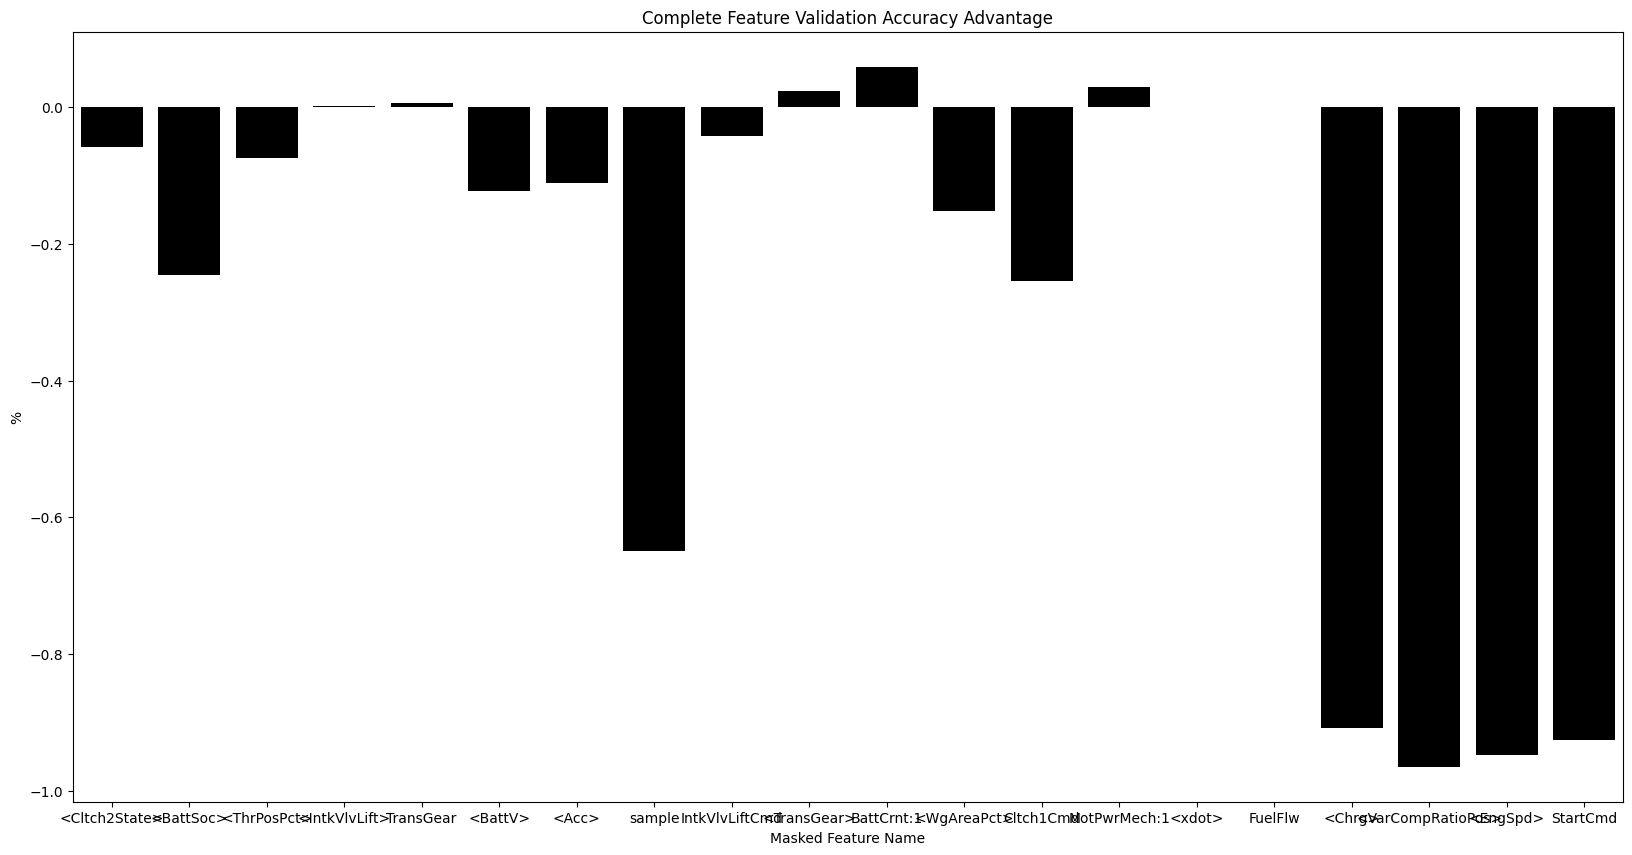

In [ ]:
x_1, y_1 = plot_dict(evoi_dict)
#y_1_100 = [z * 100 for z in y_1]
plt.figure(figsize=(20,10))
sns.barplot(x=x_1,y= y_1, palette = mpl.cm.ScalarMappable(cmap=sns.dark_palette("#69d", reverse=False, as_cmap=True)).to_rgba(y_1))
#plt.xticks(rotation=45);
#plt.ylim((-5.0, 16.0))
plt.title('Complete Feature Validation Accuracy Advantage')
plt.ylabel('%')
plt.xlabel('Masked Feature Name');

#Heatmap

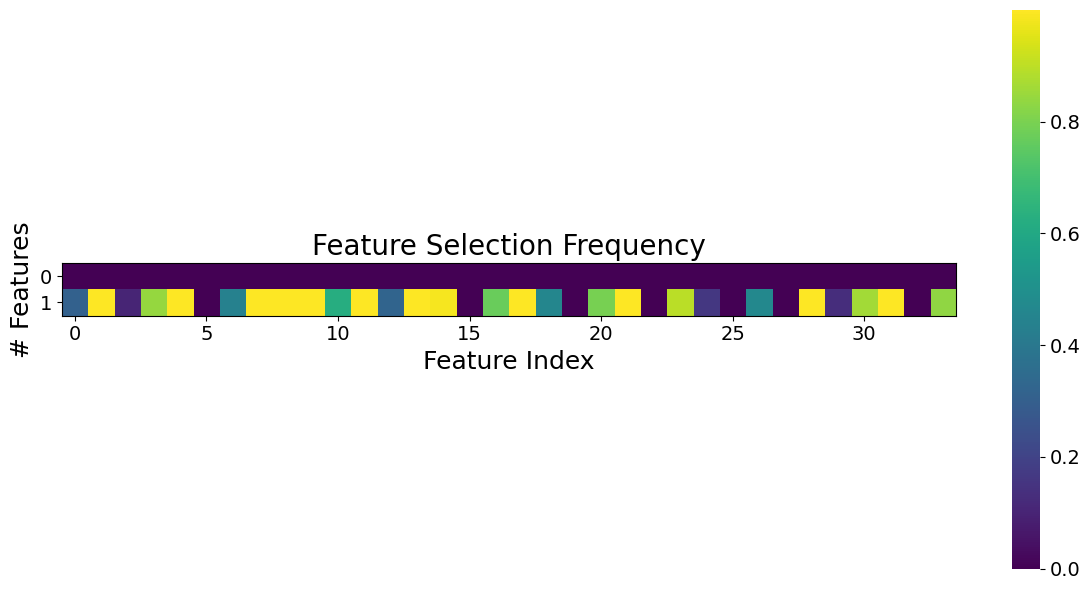

In [ ]:
plt.figure(figsize=(12, 6))

# Plot heatmap.
heatmap = np.stack([np.zeros(len(p_list[0]))] + p_list)
plt.imshow(heatmap, cmap='viridis')

# Labels.
plt.xlabel('Feature Index', fontsize=18)
plt.ylabel('# Features', fontsize=18)
plt.title('Feature Selection Frequency', fontsize=20)
plt.tick_params(labelsize=14)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)
cbar.outline.set_visible(False)

plt.tight_layout()
plt.show()